## Import Required Libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

## Upload and Extract the Facebook Dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving facebook.tar.gz to facebook.tar.gz


In [3]:
import tarfile

with tarfile.open("facebook.tar.gz", "r:gz") as tar:
    tar.extractall("facebook")  # Extract to folder called 'facebook'

print(os.listdir("facebook"))

['facebook']


## Load Facebook Ego Network

In [4]:
G = nx.read_edgelist("facebook/facebook/0.edges")
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 333, Edges: 2519


## Calculate Fraction of Users Experiencing Friendship Paradox
Defines a function to compute a user’s average friend degree and checks if most users have friends with more friends than them — i.e., the **friendship paradox**.
This cell calculates and prints the fraction of users for whom the paradox holds.

In [5]:
def avg_friend_degree(G, node):
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return 0
    degrees = [G.degree(nbr) for nbr in neighbors]
    return np.mean(degrees)

paradox_count = 0
for node in G.nodes():
    user_deg = G.degree(node)
    friend_deg = avg_friend_degree(G, node)
    if friend_deg > user_deg:
        paradox_count += 1

fraction = paradox_count / G.number_of_nodes()
print(f"Fraction of users experiencing the friendship paradox: {fraction:.4f}")

Fraction of users experiencing the friendship paradox: 0.7658


## Visualize Friendship Paradox Scatter Plot

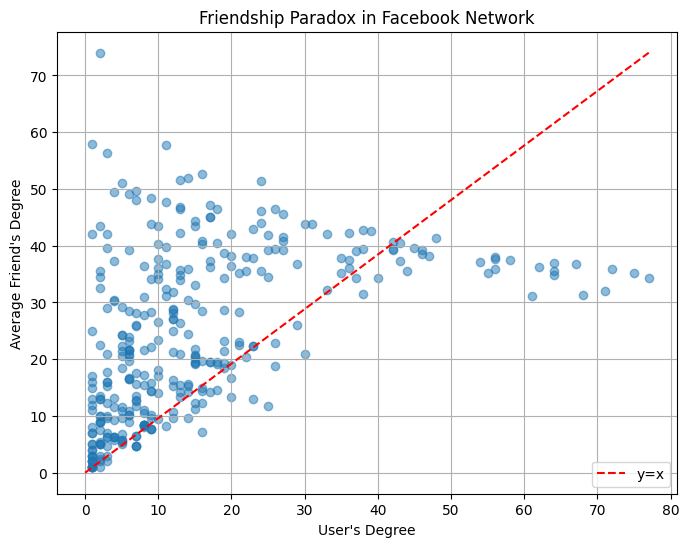

In [6]:
user_degrees = []
friend_degrees = []

for node in G.nodes():
    user_degrees.append(G.degree(node))
    friend_degrees.append(avg_friend_degree(G, node))

plt.figure(figsize=(8,6))
plt.scatter(user_degrees, friend_degrees, alpha=0.5)
plt.plot([0, max(user_degrees)], [0, max(friend_degrees)], 'r--', label="y=x")
plt.xlabel("User's Degree")
plt.ylabel("Average Friend's Degree")
plt.title("Friendship Paradox in Facebook Network")
plt.legend()
plt.grid(True)
plt.show()

## Calculate Average Paradox Strength
Computes the paradox strength as the ratio of average friend degree to the user’s own degree and prints the average of these ratios across the network.

In [7]:
strengths = []
for node in G.nodes():
    user_deg = G.degree(node)
    avg_deg = avg_friend_degree(G, node)
    if user_deg > 0:
        strengths.append(avg_deg / user_deg)

print(f"Average paradox strength ratio: {np.mean(strengths):.2f}")

Average paradox strength ratio: 3.32


## Plot Degree Distribution

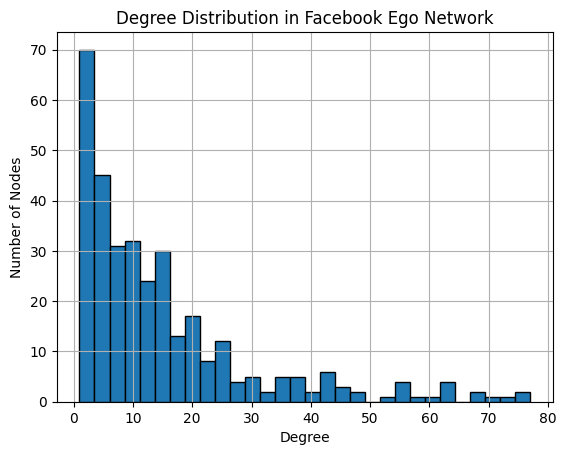

In [8]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=30, edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution in Facebook Ego Network")
plt.grid(True)
plt.show()

## Plot Paradox Strength Distribution

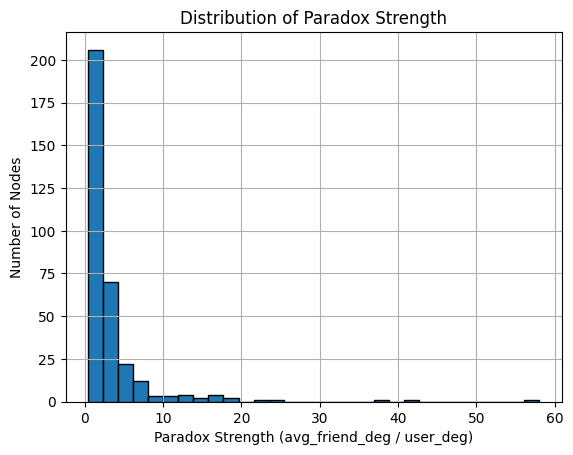

In [9]:
plt.hist(strengths, bins=30, edgecolor='black')
plt.xlabel("Paradox Strength (avg_friend_deg / user_deg)")
plt.ylabel("Number of Nodes")
plt.title("Distribution of Paradox Strength")
plt.grid(True)
plt.show()

## Compute Centrality Metrics (Betweenness & Closeness)
Computes betweenness and closeness centrality for all nodes to identify key influencers or important connectors in the network.

In [10]:
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)

# Top 5 by betweenness
sorted_bet = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by betweenness centrality:")
for node, val in sorted_bet:
    print(f"{node}: {val:.4f}")

Top 5 nodes by betweenness centrality:
277: 0.2659
175: 0.2461
19: 0.1788
23: 0.1302
25: 0.0854


## Community Detection with Modularity
Uses the greedy modularity algorithm to detect communities (groups of tightly connected users) and prints the number of such communities and their sizes.

In [11]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
print(f"Detected {len(communities)} communities.")
print(f"Community sizes: {[len(c) for c in communities[:5]]}...")

Detected 12 communities.
Community sizes: [119, 52, 47, 33, 32]...


## Compare with Random Graph
Generates a random graph with the same number of nodes and edges to compare how often the friendship paradox holds in a structureless network.

In [12]:
G_random = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())

paradox_count_rand = 0
for node in G_random.nodes():
    neighbors = list(G_random.neighbors(node))
    if neighbors:
        user_deg = G_random.degree(node)
        avg_deg = np.mean([G_random.degree(nbr) for nbr in neighbors])
        if avg_deg > user_deg:
            paradox_count_rand += 1

fraction_rand = paradox_count_rand / G_random.number_of_nodes()
print(f"Friendship paradox holds for {fraction_rand:.4f} of nodes in random graph.")

Friendship paradox holds for 0.6276 of nodes in random graph.


## Friendship Paradox in Multiple Ego Networks
Iterates over multiple ego-networks (0–9) and calculates the fraction of users experiencing the paradox in each — useful for comparing how consistent the paradox is across different networks.

In [13]:
results = []
for i in range(10):
    path = f"facebook/facebook/{i}.edges"
    if os.path.exists(path):
        G_temp = nx.read_edgelist(path)
        count = 0
        for node in G_temp.nodes():
            neighbors = list(G_temp.neighbors(node))
            if neighbors:
                user_deg = G_temp.degree(node)
                avg_deg = np.mean([G_temp.degree(nbr) for nbr in neighbors])
                if avg_deg > user_deg:
                    count += 1
        ratio = count / G_temp.number_of_nodes()
        results.append((i, ratio))
        print(f"Ego network {i}: {ratio:.4f}")

Ego network 0: 0.7658


In [15]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00


## Visualize Network with PyVis

In [43]:
net = Network(notebook=True, height="600px", width="100%", bgcolor="#222222",
              font_color="white", cdn_resources="in_line")
net.from_nx(G)
net.toggle_physics(True)
net.show_buttons(filter_=['physics'])
html_path = "facebook_graph.html"
net.write_html(html_path)

from IPython.display import display, HTML

with open(html_path, 'r') as f:
    html_content = f.read()

display(HTML(html_content))

## Identify Top Paradoxical Nodes
Sorts and prints the top 10 nodes with the highest paradox strength, showing who experiences the paradox most severely.

In [26]:
# Sort nodes by paradox strength
top_paradox = sorted(node_strengths.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Paradoxical Nodes:")
for node, strength in top_paradox:
    print(f"{node}: {strength:.2f}")

Top 10 Paradoxical Nodes:
234: 58.00
153: 42.00
207: 37.00
305: 25.00
336: 21.75
288: 18.78
76: 17.75
294: 17.25
183: 17.00
164: 16.25


## Compare Betweenness with Random Graph
Computes and compares betweenness centrality between the real Facebook graph and a random graph — illustrating structural differences in influence and information flow.

In [27]:
import networkx as nx

# Create random graph
G_rand = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())

# Calculate betweenness
bt_orig = nx.betweenness_centrality(G)
bt_rand = nx.betweenness_centrality(G_rand)

# Compare top nodes
top_orig = sorted(bt_orig.items(), key=lambda x: x[1], reverse=True)[:5]
top_rand = sorted(bt_rand.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top Betweenness in Facebook Network:")
for node, score in top_orig:
    print(f"{node}: {score:.4f}")

print("\nTop Betweenness in Random Graph:")
for node, score in top_rand:
    print(f"{node}: {score:.4f}")

Top Betweenness in Facebook Network:
277: 0.2659
175: 0.2461
19: 0.1788
23: 0.1302
25: 0.0854

Top Betweenness in Random Graph:
232: 0.0119
234: 0.0108
166: 0.0107
223: 0.0101
255: 0.0098


## Save Degree and Paradox Strength to CSV

In [28]:
import pandas as pd

data = []
for node in G.nodes():
    deg = G.degree(node)
    strength = node_strengths[node]
    data.append({"Node": node, "Degree": deg, "Paradox_Strength": strength})

df = pd.DataFrame(data)
df.to_csv("paradox_analysis.csv", index=False)
print("Saved to paradox_analysis.csv")

Saved to paradox_analysis.csv


## Analyze Paradox Strength per Community
Calculates and prints the average paradox strength per community, helping identify whether some social groups are more paradox-prone than others.



In [29]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))

# Average paradox strength per community
for i, community in enumerate(communities[:5]):  # first 5
    strengths = [node_strengths[node] for node in community if node in node_strengths]
    avg_strength = np.mean(strengths)
    print(f"Community {i+1}: {len(community)} nodes, Avg Paradox Strength: {avg_strength:.2f}")

Community 1: 119 nodes, Avg Paradox Strength: 4.03
Community 2: 52 nodes, Avg Paradox Strength: 3.19
Community 3: 47 nodes, Avg Paradox Strength: 2.70
Community 4: 33 nodes, Avg Paradox Strength: 2.99
Community 5: 32 nodes, Avg Paradox Strength: 4.14


In [42]:
from google.colab import files
files.download("paradox_analysis.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>